In [25]:
# https://www.pywhy.org/dowhy/v0.10.1/user_guide/causal_tasks/estimating_causal_effects/index.html

# Estimating the causal effect requires four steps:

# Model a causal inference problem using assumptions.

#     Identify an expression for the causal effect under these assumptions (“causal estimand”).
#     Estimate the expression using statistical methods such as matching or instrumental variables.
#     Finally, verify the validity of the estimate using a variety of robustness checks.

# This workflow is captured by four key verbs in DoWhy:

#     model (CausalModel or graph)
#     identify (identify_effect)
#     estimate (estimate_effect)
#     refute (refute_estimate)


#https://www.pywhy.org/dowhy/v0.10.1/example_notebooks/dowhy_simple_example.html#

In [26]:
import networkx as nx
import pandas as pd
from dowhy import gcm
from dowhy import CausalModel
import numpy as np
import matplotlib.pyplot as plt

from dowhy.utils import plot, bar_plot

In [27]:
#Treat dataset

#Import data 
# data = pd.read_csv('../datasets/consolidated.csv',header=0, index_col=0)
data = pd.read_csv('../../../Datasets/Networkwise/consolidated_5s.csv',header=0, index_col=0)
consolidated = pd.DataFrame(data)


consolidated = consolidated.drop(columns=['experiment', 'topology'])#, 'messageBandwidth'])#, 'gossipBandwidth'])#, 'messageDuplicated'])#, 'n_nodes', 'consensus', 'messageDuplicated'])
# consolidated = consolidated.loc[consolidated['totalBandwidth'] > 0]
# consolidated.head(100)

consolidateddiff = consolidated.dropna()#.diff().dropna()

X = consolidateddiff[['d', 'messageReceived', 'graft', 'prune', 'dlo', 'dhi', 'dout', 'interval', 'messageOverhead', 'topics', 'topicSize']].to_numpy()
consolidated = consolidateddiff[['d', 'messageReceived', 'graft', 'prune', 'dlo', 'dhi', 'dout', 'interval', 'messageOverhead', 'topics', 'topicSize']]

#Rearrange columns according to nodes list
# nodes = causal_graph.nodes

# X = consolidated[['d', 'messageReceived', 'graft', 'prune', 'iwant', 'dlo', 'dhi', 'dscore', 'dlazy', 'ihave', 'dout', 'gossipFactor', 'interval', 'messageOverhead']].to_numpy()

# X = consolidated.to_numpy()
# print(X)
consolidated.head(500)

,d,messageReceived,graft,prune,dlo,dhi,dout,interval,messageOverhead,topics,topicSize
0,8,43.0,0.0,0.0,6,12,2,1.0,321.0,1,16
1,8,54.0,0.0,0.0,6,12,2,1.0,389.0,1,16
2,8,96.0,0.0,0.0,6,12,2,1.0,702.0,1,16
3,8,88.0,0.0,0.0,6,12,2,1.0,629.0,1,16
4,8,61.0,0.0,0.0,6,12,2,1.0,454.0,1,16
...,...,...,...,...,...,...,...,...,...,...,...
495,16,18.0,0.0,0.0,8,20,4,0.5,62.0,1,16
496,16,56.0,0.0,0.0,8,20,4,0.5,250.0,1,16
497,16,50.0,0.0,0.0,8,20,4,0.5,175.0,1,16
498,16,58.0,0.0,0.0,8,20,4,0.5,239.0,1,16


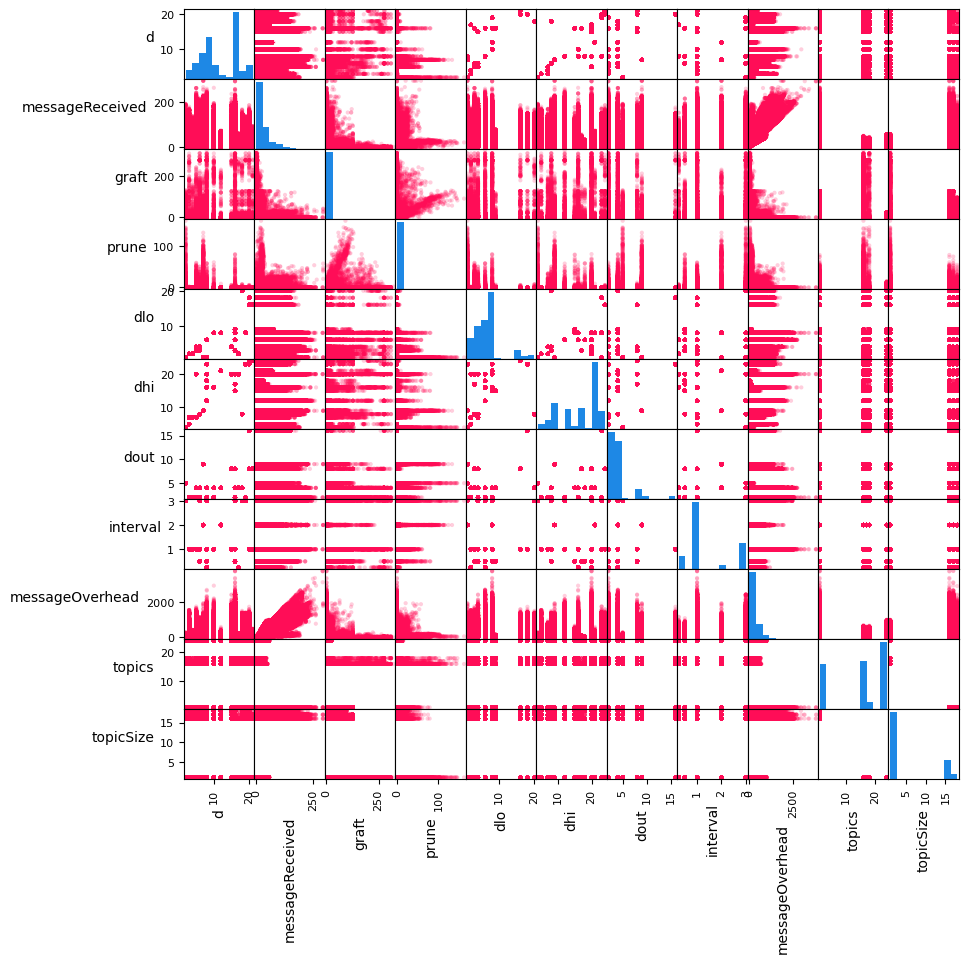

In [28]:
axes = pd.plotting.scatter_matrix(consolidated, figsize=(10, 10), c='#ff0d57', alpha=0.2, hist_kwds={'color':['#1E88E5']});
for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')

######################################################
#  Manual
######################################################

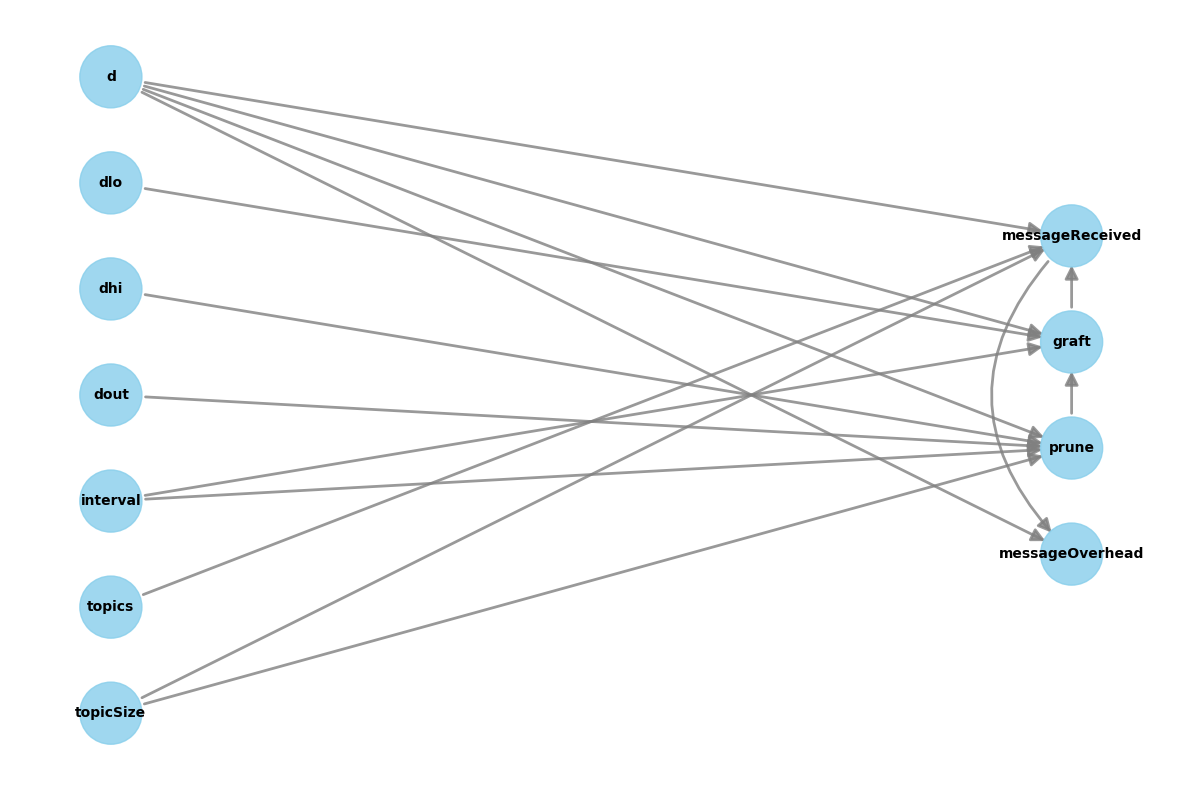

In [29]:
#Manual
#Causal graph
causal_graph = nx.DiGraph([('d', 'messageReceived'),
                           ('d', 'graft'),
                           ('d', 'prune'),
                           ('dlo', 'graft'),
                           ('dhi', 'prune'),
                           ('dout', 'prune'),
                           ('interval', 'graft'),
                           ('interval', 'prune'),
                           ('prune', 'graft'),
                           ('messageReceived', 'messageOverhead'),
                           ('graft','messageReceived'),
                           ('topics', 'messageReceived'),
                           ('d', 'messageOverhead'),
                           ('topicSize', 'messageReceived'),
                           ('topicSize','prune'),
                         ])


G=gcm.util.plot(causal_graph, figure_size=[15, 10])
# cons


from scipy.stats import halfnorm

causal_model = gcm.StructuralCausalModel(causal_graph)

In [30]:
#From digraph to adjancency matrix

# true_causal_matrix = nx.adjacency_matrix(causal_graph)
true_causal_matrix = nx.to_numpy_array(causal_graph)

print(true_causal_matrix)
print(causal_graph.nodes)

[[0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
['d', 'messageReceived', 'graft', 'prune', 'dlo', 'dhi', 'dout', 'interval', 'messageOverhead', 'topics', 'topicSize']


In [31]:
gcm.auto.assign_causal_mechanisms(causal_model, consolidated)

Test permutations of given graph: 100%|██████████| 50/50 [01:34<00:00,  1.88s/it]


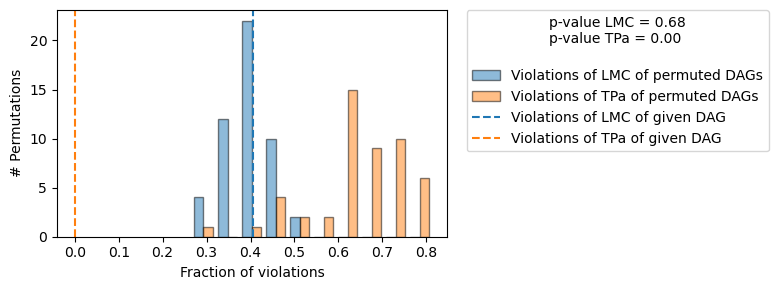

Evaluated the performance of the causal mechanisms and the invertibility assumption of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the under

In [32]:
gcm.fit(causal_model, consolidated)
print(gcm.evaluate_causal_model(causal_model, consolidated))

######################################################
# PC 
######################################################

In [35]:
# PC normal
causal_graph = nx.read_adjlist("../../../1_Discovery/MessageOverhead/NetworkWise/pc5s.adjlist", create_using=nx.DiGraph)

gml_graph = "\n".join(nx.generate_gml(causal_graph))
# pos = nx.nx_agraph.graphviz_layout(causal_graph, prog="dot")
# nx.draw(causal_graph, pos, with_labels=True, node_size=1000)

In [36]:
#From digraph to adjancency matrix

# true_causal_matrix = nx.adjacency_matrix(causal_graph)
true_causal_matrix = nx.to_numpy_array(causal_graph)

print(true_causal_matrix)
print(causal_graph.nodes)

[[0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]]
['d', 'messageReceived', 'prune', 'messageOverhead', 'graft', 'dlo', 'dhi', 'dout', 'interval', 'topics', 'topicSize']


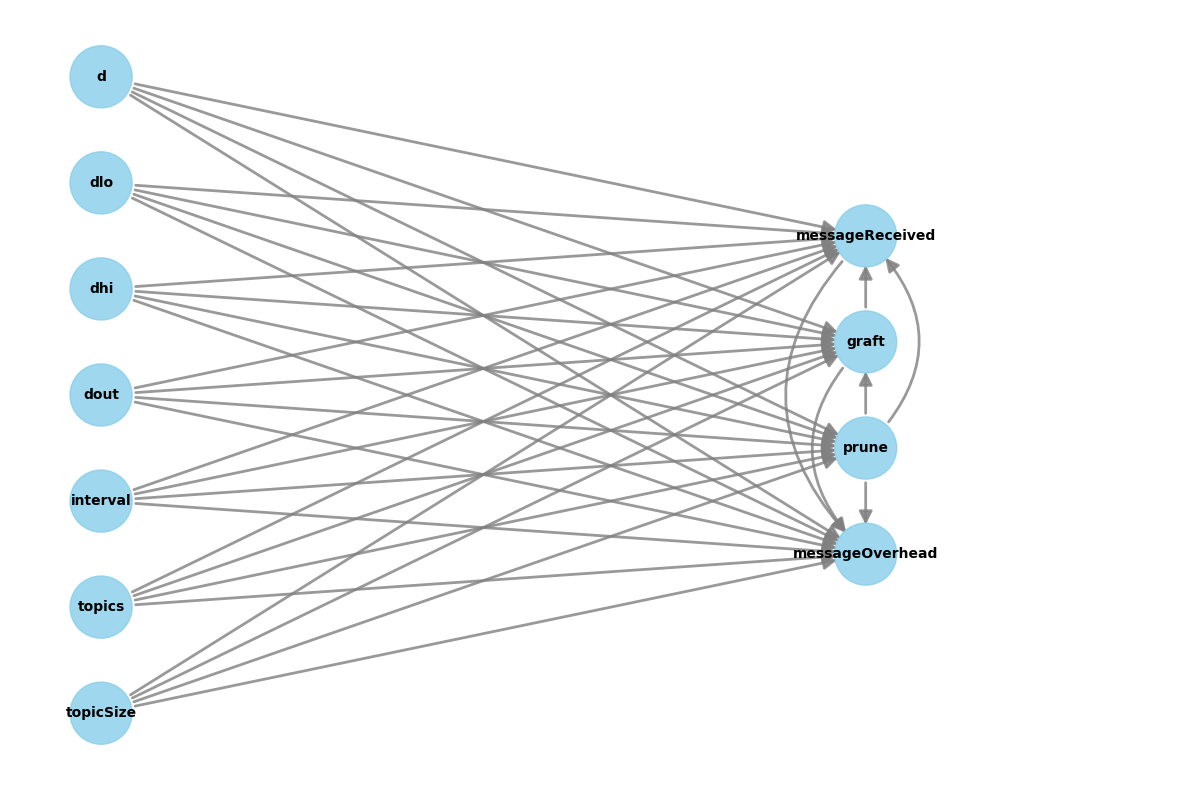

In [67]:
gcm.util.plot(causal_graph, figure_size=[15, 10])

In [38]:
#Fitting with mechanisms from the example: https://www.pywhy.org/dowhy/v0.10.1/example_notebooks/gcm_rca_microservice_architecture.html

from scipy.stats import halfnorm

causal_model = gcm.StructuralCausalModel(causal_graph)

In [39]:
#Causal model didn't look good, so we try auto assign the causal mechanisms, according to 
#    https://aws.amazon.com/pt/blogs/opensource/root-cause-analysis-with-dowhy-an-open-source-python-library-for-causal-machine-learning/

# Automatically assign generative models to each node based on the given data
consolidated = consolidated.dropna()
gcm.auto.assign_causal_mechanisms(causal_model, consolidated)

Test permutations of given graph:  46%|████▌     | 23/50 [00:41<00:46,  1.71s/it]/home/flav/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Test permutations of given graph: 100%|██████████| 50/50 [01:33<00:00,  1.87s/it]


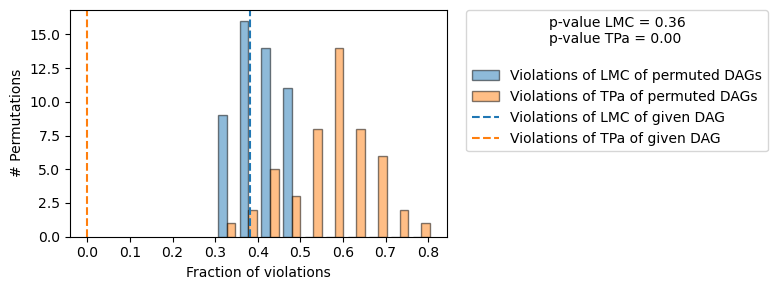

Evaluated the performance of the causal mechanisms and the invertibility assumption of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the under

In [40]:
gcm.fit(causal_model, consolidated)
print(gcm.evaluate_causal_model(causal_model, consolidated))

######################################################
# PC diff
######################################################

In [41]:
# PC normal
causal_graph = nx.read_adjlist("../../../1_Discovery/MessageOverhead/NetworkWise/pcDiff5s.adjlist", create_using=nx.DiGraph)
consolidatedDiff = consolidated.dropna().diff().dropna()

gml_graph = "\n".join(nx.generate_gml(causal_graph))
# pos = nx.nx_agraph.graphviz_layout(causal_graph, prog="dot")
# nx.draw(causal_graph, pos, with_labels=True, node_size=1000)

In [42]:
#From digraph to adjancency matrix

# true_causal_matrix = nx.adjacency_matrix(causal_graph)
true_causal_matrix = nx.to_numpy_array(causal_graph)

print(true_causal_matrix)
print(causal_graph.nodes)

[[0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]]
['d', 'messageReceived', 'prune', 'messageOverhead', 'graft', 'dlo', 'dhi', 'dout', 'interval', 'topics', 'topicSize']


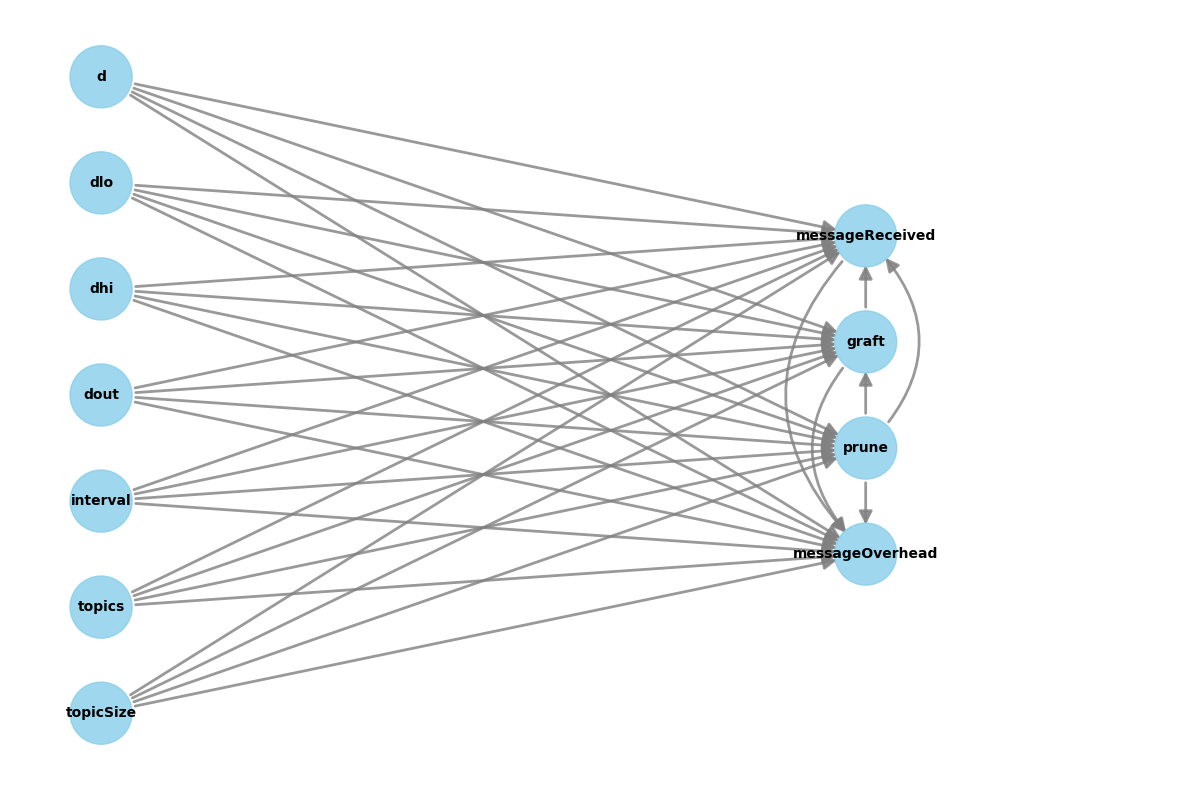

In [68]:
gcm.util.plot(causal_graph, figure_size=[15, 10])

In [44]:
#Fitting with mechanisms from the example: https://www.pywhy.org/dowhy/v0.10.1/example_notebooks/gcm_rca_microservice_architecture.html

from scipy.stats import halfnorm

causal_model = gcm.StructuralCausalModel(causal_graph)

In [45]:
#Causal model didn't look good, so we try auto assign the causal mechanisms, according to 
#    https://aws.amazon.com/pt/blogs/opensource/root-cause-analysis-with-dowhy-an-open-source-python-library-for-causal-machine-learning/

# Automatically assign generative models to each node based on the given data
consolidated = consolidated.dropna()
gcm.auto.assign_causal_mechanisms(causal_model, consolidatedDiff)

Test permutations of given graph: 100%|██████████| 50/50 [01:04<00:00,  1.30s/it]


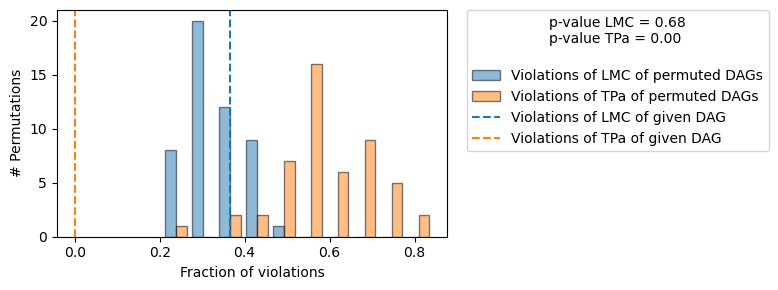

Evaluated the performance of the causal mechanisms and the invertibility assumption of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the under

In [46]:
gcm.fit(causal_model, consolidated)
print(gcm.evaluate_causal_model(causal_model, consolidatedDiff))

# Intersection

In [69]:
# PC normal
causal_graph = nx.read_adjlist("../../../1_Discovery/MessageOverhead/NetworkWise/intersection.adjlist", create_using=nx.DiGraph)
consolidatedDiff = consolidated.dropna()#.diff().dropna()

gml_graph = "\n".join(nx.generate_gml(causal_graph))
# pos = nx.nx_agraph.graphviz_layout(causal_graph, prog="dot")
# nx.draw(causal_graph, pos, with_labels=True, node_size=1000)

In [70]:
#From digraph to adjancency matrix

# true_causal_matrix = nx.adjacency_matrix(causal_graph)
true_causal_matrix = nx.to_numpy_array(causal_graph)

print(true_causal_matrix)
print(causal_graph.nodes)

[[0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0.]]
['dhi', 'messageOverhead', 'prune', 'dout', 'graft', 'messageReceived', 'topicSize', 'dlo', 'interval', 'd', 'topics']


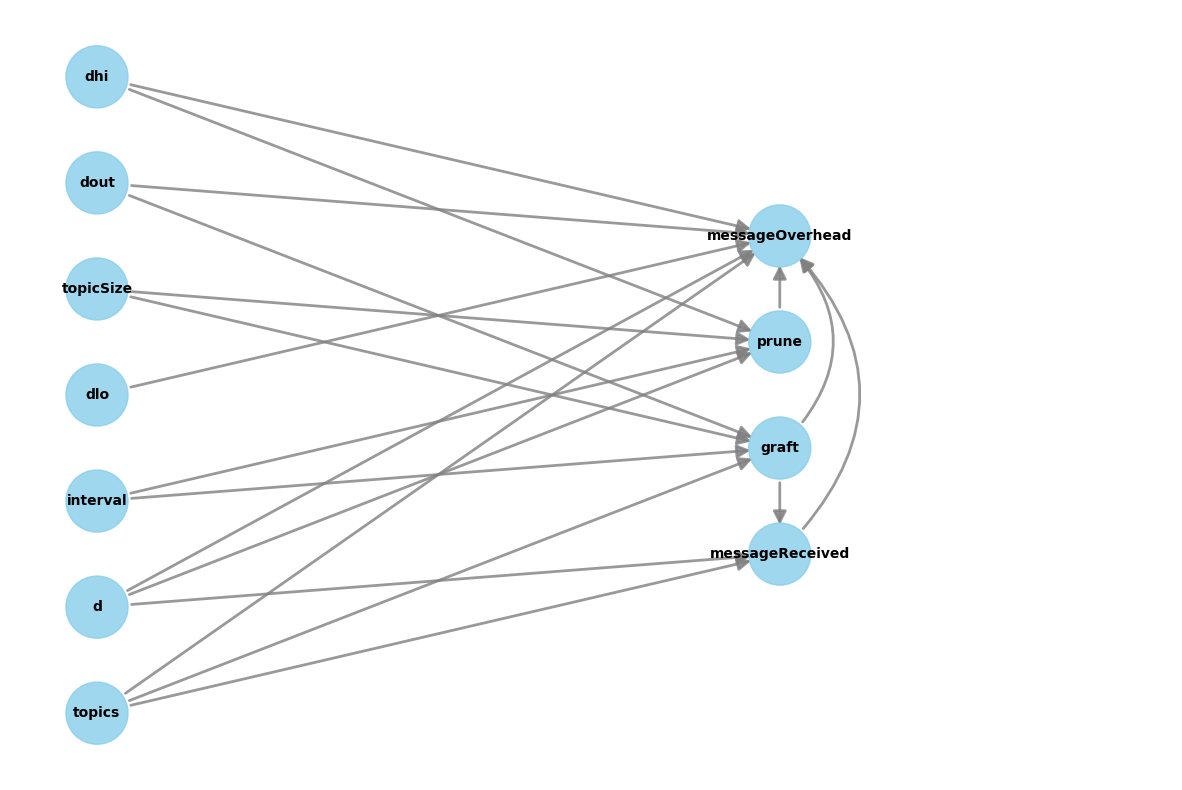

In [71]:
gcm.util.plot(causal_graph, figure_size=[15, 10])

In [73]:
#Causal model didn't look good, so we try auto assign the causal mechanisms, according to 
#    https://aws.amazon.com/pt/blogs/opensource/root-cause-analysis-with-dowhy-an-open-source-python-library-for-causal-machine-learning/

# Automatically assign generative models to each node based on the given data
consolidated = consolidated.dropna()
gcm.auto.assign_causal_mechanisms(causal_model, consolidated)

Test permutations of given graph: 100%|██████████| 50/50 [00:02<00:00, 20.24it/s]


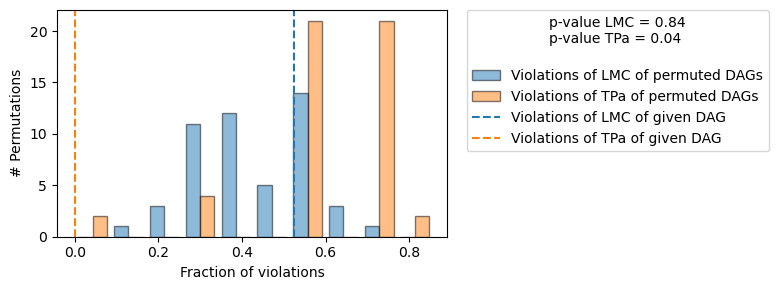

Evaluated the performance of the causal mechanisms and the invertibility assumption of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the under

In [74]:
gcm.fit(causal_model, consolidated)
print(gcm.evaluate_causal_model(causal_model, consolidated))